In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Pre-processing

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
set.seed(2024)
data = pd.read_csv("/content/drive/MyDrive/cnn_pred/Processed_NASDAQ.csv")

data_clean = data.drop(columns=['Date', 'Name'])

features = data_clean.drop(columns=['Close'])
target = data_clean['Close']

missing_mask = features.isnull()

scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features.fillna(0))

train_data_tensor = torch.tensor(features_scaled, dtype=torch.float32)



In [ ]:
data.head(10)

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,2269.149902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,2308.419922,0.560308,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,2308.709961,0.225994,0.000126,0.017306,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,2301.090088,-0.048364,-0.003300,0.000126,0.017306,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,2300.050049,0.007416,-0.000452,-0.003300,0.000126,0.017306,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58
5,2010-01-08,2317.169922,-0.054915,0.007443,-0.000452,-0.003300,0.000126,2.116212,NaN,NaN,...,0.61,0.68,0.64,0.35,-0.98,-0.58,-0.56,2.07,1.26,0.38
6,2010-01-11,2312.409912,-0.031463,-0.002054,0.007443,-0.000452,-0.003300,0.172845,NaN,NaN,...,0.64,-0.13,-1.01,0.09,-0.66,-0.64,-0.61,1.08,0.65,1.44
7,2010-01-12,2282.310059,0.139772,-0.013017,-0.002054,0.007443,-0.000452,-1.143491,NaN,NaN,...,-0.47,-2.36,-0.67,-0.74,0.22,-0.05,-0.06,-6.33,-1.78,-2.19
8,2010-01-13,2307.899902,-0.021099,0.011212,-0.013017,-0.002054,0.007443,0.295939,NaN,NaN,...,0.26,1.62,0.82,0.66,-0.15,-0.17,-0.13,-0.51,1.97,0.98
9,2010-01-14,2316.739990,-0.027683,0.003830,0.011212,-0.013017,-0.002054,0.725634,NaN,NaN,...,0.27,0.57,0.76,0.33,0.12,-0.13,-0.16,-1.49,0.32,0.39


# Define the GAN Model

In [ ]:
import optuna
import torch
import torch.nn as nn



class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


def objective(trial):


    hidden_dim1 = trial.suggest_int('hidden_dim1', 64, 512)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 64, 512)
    lr_generator = trial.suggest_loguniform('lr_generator', 1e-5, 1e-2)
    lr_discriminator = trial.suggest_loguniform('lr_discriminator', 1e-5, 1e-2)
    latent_dim = trial.suggest_int('latent_dim', 50, 200)


    generator = Generator(latent_dim, input_dim, hidden_dim1, hidden_dim2)
    discriminator = Discriminator(input_dim, hidden_dim1, hidden_dim2)


    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_generator)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator)


    epochs = 1000
    batch_size = 64
    loss_function = nn.BCELoss()

    for epoch in range(epochs):

        z = torch.randn(batch_size, latent_dim)
        generated_data = generator(z)

        real_data = train_data_tensor[torch.randint(0, len(train_data_tensor), (batch_size,))]
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        optimizer_D.zero_grad()
        real_loss = loss_function(discriminator(real_data), real_labels)
        fake_loss = loss_function(discriminator(generated_data.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()


        optimizer_G.zero_grad()
        g_loss = loss_function(discriminator(generated_data), real_labels)
        g_loss.backward()
        optimizer_G.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D loss: {d_loss.item()}, G loss: {g_loss.item()}")


    return g_loss.item()


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial: ", study.best_trial.params)


[I 2024-10-05 22:10:43,923] A new study created in memory with name: no-name-cd049d76-3d5d-4114-a1ea-8f375efa2bfb
<ipython-input-39-6d0fd916e200>:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_generator = trial.suggest_loguniform('lr_generator', 1e-5, 1e-2)
<ipython-input-39-6d0fd916e200>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_discriminator = trial.suggest_loguniform('lr_discriminator', 1e-5, 1e-2)


Epoch 0, D loss: 1.3819279670715332, G loss: 0.6587232351303101
Epoch 100, D loss: 0.0008171035442501307, G loss: 12.674905776977539
Epoch 200, D loss: 0.03564094379544258, G loss: 11.270197868347168
Epoch 300, D loss: 0.015107424929738045, G loss: 8.221758842468262
Epoch 400, D loss: 0.04994506761431694, G loss: 5.209397792816162
Epoch 500, D loss: 0.07036788761615753, G loss: 9.945627212524414
Epoch 600, D loss: 0.018973950296640396, G loss: 6.20048713684082
Epoch 700, D loss: 0.012753292918205261, G loss: 6.7562665939331055
Epoch 800, D loss: 0.029753699898719788, G loss: 6.125356674194336
Epoch 900, D loss: 0.036309562623500824, G loss: 6.50593900680542


[I 2024-10-05 22:11:09,840] Trial 0 finished with value: 5.636632919311523 and parameters: {'hidden_dim1': 380, 'hidden_dim2': 227, 'lr_generator': 0.00024977225928598845, 'lr_discriminator': 0.001717731678572352, 'latent_dim': 97}. Best is trial 0 with value: 5.636632919311523.


Epoch 0, D loss: 1.3855551481246948, G loss: 0.6512265801429749
Epoch 100, D loss: 0.3918974995613098, G loss: 1.8904478549957275
Epoch 200, D loss: 0.8936461806297302, G loss: 1.177417516708374
Epoch 300, D loss: 0.7849715948104858, G loss: 1.5529870986938477
Epoch 400, D loss: 0.9555588960647583, G loss: 1.534538984298706
Epoch 500, D loss: 0.47565191984176636, G loss: 1.8868919610977173
Epoch 600, D loss: 0.15896864235401154, G loss: 4.092580318450928
Epoch 700, D loss: 0.13214944303035736, G loss: 3.3941893577575684
Epoch 800, D loss: 0.0652744397521019, G loss: 5.063162326812744
Epoch 900, D loss: 0.046105965971946716, G loss: 5.84730863571167


[I 2024-10-05 22:11:16,653] Trial 1 finished with value: 6.599404335021973 and parameters: {'hidden_dim1': 202, 'hidden_dim2': 94, 'lr_generator': 0.002908392271810952, 'lr_discriminator': 0.00016006577960431278, 'latent_dim': 134}. Best is trial 0 with value: 5.636632919311523.


Epoch 0, D loss: 1.3902417421340942, G loss: 0.6836687326431274
Epoch 100, D loss: 0.4654613137245178, G loss: 2.0677103996276855
Epoch 200, D loss: 0.23388977348804474, G loss: 3.482879877090454
Epoch 300, D loss: 1.0507619380950928, G loss: 1.4852478504180908
Epoch 400, D loss: 1.039884328842163, G loss: 1.1295231580734253
Epoch 500, D loss: 0.5208157300949097, G loss: 2.2901816368103027
Epoch 600, D loss: 0.3891231417655945, G loss: 2.8361597061157227
Epoch 700, D loss: 1.5279388427734375, G loss: 1.5499687194824219
Epoch 800, D loss: 0.3497410714626312, G loss: 2.753912925720215
Epoch 900, D loss: 0.46697214245796204, G loss: 2.311380386352539


[I 2024-10-05 22:11:22,379] Trial 2 finished with value: 1.55475914478302 and parameters: {'hidden_dim1': 76, 'hidden_dim2': 416, 'lr_generator': 0.00024541429577830853, 'lr_discriminator': 0.0004905798610373313, 'latent_dim': 73}. Best is trial 2 with value: 1.55475914478302.


Epoch 0, D loss: 1.3776735067367554, G loss: 0.7287184596061707
Epoch 100, D loss: 1.4876463413238525, G loss: 0.6103285551071167
Epoch 200, D loss: 1.382298469543457, G loss: 0.6912374496459961
Epoch 300, D loss: 1.3926124572753906, G loss: 0.6750602722167969
Epoch 400, D loss: 1.4477829933166504, G loss: 0.6217090487480164
Epoch 500, D loss: 1.479241967201233, G loss: 0.617149829864502
Epoch 600, D loss: 1.4335076808929443, G loss: 0.6680196523666382
Epoch 700, D loss: 1.398976445198059, G loss: 0.6987072229385376
Epoch 800, D loss: 1.3912798166275024, G loss: 0.7030887603759766
Epoch 900, D loss: 1.4301702976226807, G loss: 0.6800664663314819


[I 2024-10-05 22:11:29,290] Trial 3 finished with value: 0.6897579431533813 and parameters: {'hidden_dim1': 110, 'hidden_dim2': 256, 'lr_generator': 0.0005678620610997388, 'lr_discriminator': 1.5191161637151923e-05, 'latent_dim': 97}. Best is trial 3 with value: 0.6897579431533813.


Epoch 0, D loss: 1.3955074548721313, G loss: 0.7096232175827026
Epoch 100, D loss: 0.002123821061104536, G loss: 6.644423961639404
Epoch 200, D loss: 0.0015298397047445178, G loss: 10.323098182678223
Epoch 300, D loss: 0.028648940846323967, G loss: 12.732808113098145
Epoch 400, D loss: 0.004682501778006554, G loss: 9.67519760131836
Epoch 500, D loss: 0.004704347811639309, G loss: 10.31777286529541
Epoch 600, D loss: 0.002153386129066348, G loss: 9.942164421081543
Epoch 700, D loss: 0.018474141135811806, G loss: 8.27842903137207
Epoch 800, D loss: 0.009327597916126251, G loss: 10.238175392150879
Epoch 900, D loss: 0.007836789824068546, G loss: 8.08578872680664


[I 2024-10-05 22:11:40,410] Trial 4 finished with value: 10.466063499450684 and parameters: {'hidden_dim1': 493, 'hidden_dim2': 185, 'lr_generator': 3.645202145444315e-05, 'lr_discriminator': 0.0010779551058962933, 'latent_dim': 106}. Best is trial 3 with value: 0.6897579431533813.


Epoch 0, D loss: 1.4094715118408203, G loss: 0.7024667859077454
Epoch 100, D loss: 0.18668973445892334, G loss: 3.3420724868774414
Epoch 200, D loss: 1.1884424686431885, G loss: 0.8540310859680176
Epoch 300, D loss: 2.743610382080078, G loss: 0.10781113058328629
Epoch 400, D loss: 0.6191412806510925, G loss: 2.1941351890563965
Epoch 500, D loss: 0.31309545040130615, G loss: 2.570234537124634
Epoch 600, D loss: 0.12196233868598938, G loss: 3.965198040008545
Epoch 700, D loss: 0.04387754201889038, G loss: 4.457395076751709
Epoch 800, D loss: 0.0931665301322937, G loss: 4.520495414733887
Epoch 900, D loss: 0.039439525455236435, G loss: 5.786722183227539


[I 2024-10-05 22:11:48,179] Trial 5 finished with value: 6.468350410461426 and parameters: {'hidden_dim1': 77, 'hidden_dim2': 438, 'lr_generator': 0.0025182769976128247, 'lr_discriminator': 0.00017496728860377488, 'latent_dim': 180}. Best is trial 3 with value: 0.6897579431533813.


Epoch 0, D loss: 1.4125175476074219, G loss: 0.6679170727729797
Epoch 100, D loss: 1.1243572235107422, G loss: 0.9933722019195557
Epoch 200, D loss: 0.36938026547431946, G loss: 2.543227195739746
Epoch 300, D loss: 0.1601480096578598, G loss: 3.517385244369507
Epoch 400, D loss: 0.2393663227558136, G loss: 3.5748867988586426
Epoch 500, D loss: 0.10468257963657379, G loss: 4.039597034454346
Epoch 600, D loss: 0.17919930815696716, G loss: 3.5639097690582275
Epoch 700, D loss: 0.15952157974243164, G loss: 3.3336257934570312
Epoch 800, D loss: 0.16437198221683502, G loss: 3.1790518760681152
Epoch 900, D loss: 0.2242937684059143, G loss: 3.1119089126586914


[I 2024-10-05 22:11:58,589] Trial 6 finished with value: 2.4895260334014893 and parameters: {'hidden_dim1': 439, 'hidden_dim2': 167, 'lr_generator': 0.00010914859094466867, 'lr_discriminator': 0.00019809133461008003, 'latent_dim': 154}. Best is trial 3 with value: 0.6897579431533813.


Epoch 0, D loss: 1.4088666439056396, G loss: 0.7055624723434448
Epoch 100, D loss: 0.0016573563916608691, G loss: 6.957308292388916
Epoch 200, D loss: 0.00026779697509482503, G loss: 8.888412475585938
Epoch 300, D loss: 3.847763218800537e-05, G loss: 12.054869651794434
Epoch 400, D loss: 0.013920172117650509, G loss: 7.739016532897949
Epoch 500, D loss: 0.014006335288286209, G loss: 11.718376159667969
Epoch 600, D loss: 0.0020040683448314667, G loss: 8.958536148071289
Epoch 700, D loss: 0.007617907598614693, G loss: 7.73004150390625
Epoch 800, D loss: 0.008309724740684032, G loss: 7.395815849304199
Epoch 900, D loss: 0.04957783594727516, G loss: 6.260148048400879


[I 2024-10-05 22:12:04,389] Trial 7 finished with value: 7.022548675537109 and parameters: {'hidden_dim1': 171, 'hidden_dim2': 154, 'lr_generator': 2.817206435736492e-05, 'lr_discriminator': 0.0026168726863691227, 'latent_dim': 144}. Best is trial 3 with value: 0.6897579431533813.


Epoch 0, D loss: 1.3814501762390137, G loss: 0.6910154819488525
Epoch 100, D loss: 1.3734016418457031, G loss: 0.6401141285896301
Epoch 200, D loss: 1.2736161947250366, G loss: 0.7772498726844788
Epoch 300, D loss: 1.4131643772125244, G loss: 0.6521878838539124
Epoch 400, D loss: 1.153693437576294, G loss: 1.0628100633621216
Epoch 500, D loss: 1.3258532285690308, G loss: 0.7348613142967224
Epoch 600, D loss: 1.4122810363769531, G loss: 0.7169263958930969
Epoch 700, D loss: 1.3788188695907593, G loss: 0.6771607995033264
Epoch 800, D loss: 1.4266982078552246, G loss: 0.6329558491706848
Epoch 900, D loss: 1.3307491540908813, G loss: 0.7643068432807922


[I 2024-10-05 22:12:10,037] Trial 8 finished with value: 0.6538442373275757 and parameters: {'hidden_dim1': 173, 'hidden_dim2': 109, 'lr_generator': 0.0002603941521447061, 'lr_discriminator': 7.864041277223338e-05, 'latent_dim': 126}. Best is trial 8 with value: 0.6538442373275757.


Epoch 0, D loss: 1.372687816619873, G loss: 0.6768398284912109
Epoch 100, D loss: 1.6844607591629028, G loss: 0.44395047426223755
Epoch 200, D loss: 1.4910037517547607, G loss: 0.5675909519195557
Epoch 300, D loss: 1.4730172157287598, G loss: 0.573935329914093
Epoch 400, D loss: 1.4786691665649414, G loss: 0.5682501196861267
Epoch 500, D loss: 1.3750934600830078, G loss: 0.6542941331863403
Epoch 600, D loss: 1.411097764968872, G loss: 0.6205595135688782
Epoch 700, D loss: 1.5214805603027344, G loss: 0.5420401096343994
Epoch 800, D loss: 1.416440486907959, G loss: 0.6263171434402466
Epoch 900, D loss: 1.3749892711639404, G loss: 0.6614587903022766


[I 2024-10-05 22:12:16,285] Trial 9 finished with value: 0.6213304400444031 and parameters: {'hidden_dim1': 141, 'hidden_dim2': 130, 'lr_generator': 0.0014128620603722716, 'lr_discriminator': 1.2392238838774085e-05, 'latent_dim': 135}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3847882747650146, G loss: 0.697404682636261
Epoch 100, D loss: 1.3755675554275513, G loss: 0.6812386512756348
Epoch 200, D loss: 1.1228026151657104, G loss: 0.9387015104293823
Epoch 300, D loss: 0.9015030860900879, G loss: 1.2338908910751343
Epoch 400, D loss: 0.7177124619483948, G loss: 1.5714809894561768
Epoch 500, D loss: 0.5598196387290955, G loss: 1.9100115299224854
Epoch 600, D loss: 0.413852721452713, G loss: 2.2341501712799072
Epoch 700, D loss: 0.2947712540626526, G loss: 2.5751659870147705
Epoch 800, D loss: 0.22413326799869537, G loss: 2.892982244491577
Epoch 900, D loss: 0.16132640838623047, G loss: 3.1877031326293945


[I 2024-10-05 22:12:27,936] Trial 10 finished with value: 3.4573557376861572 and parameters: {'hidden_dim1': 287, 'hidden_dim2': 337, 'lr_generator': 0.009625419735414404, 'lr_discriminator': 1.1066984006056129e-05, 'latent_dim': 54}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3898459672927856, G loss: 0.6553677916526794
Epoch 100, D loss: 1.37485671043396, G loss: 0.6273300051689148
Epoch 200, D loss: 1.406625509262085, G loss: 0.5968968868255615
Epoch 300, D loss: 1.3892407417297363, G loss: 0.6428003311157227
Epoch 400, D loss: 1.4341405630111694, G loss: 0.6246671676635742
Epoch 500, D loss: 1.3694329261779785, G loss: 0.6971104741096497
Epoch 600, D loss: 1.4473333358764648, G loss: 0.6020539999008179
Epoch 700, D loss: 1.398498773574829, G loss: 0.6490403413772583
Epoch 800, D loss: 1.4209816455841064, G loss: 0.6405988335609436
Epoch 900, D loss: 1.3775243759155273, G loss: 0.6726422905921936


[I 2024-10-05 22:12:33,407] Trial 11 finished with value: 0.6630306243896484 and parameters: {'hidden_dim1': 231, 'hidden_dim2': 68, 'lr_generator': 0.0009623766074292939, 'lr_discriminator': 3.685404269896232e-05, 'latent_dim': 182}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.393350601196289, G loss: 0.6751210689544678
Epoch 100, D loss: 1.2724010944366455, G loss: 0.7217625379562378
Epoch 200, D loss: 1.4655290842056274, G loss: 0.5449714660644531
Epoch 300, D loss: 1.215669870376587, G loss: 0.7903754115104675
Epoch 400, D loss: 1.2798603773117065, G loss: 0.7787330746650696
Epoch 500, D loss: 1.22438383102417, G loss: 0.8485739231109619
Epoch 600, D loss: 1.3793830871582031, G loss: 0.682841420173645
Epoch 700, D loss: 1.4216574430465698, G loss: 0.6694359183311462
Epoch 800, D loss: 1.42405366897583, G loss: 0.6520068645477295
Epoch 900, D loss: 1.4060142040252686, G loss: 0.6672089099884033


[I 2024-10-05 22:12:39,586] Trial 12 finished with value: 0.6574141979217529 and parameters: {'hidden_dim1': 156, 'hidden_dim2': 126, 'lr_generator': 0.0012636260285367796, 'lr_discriminator': 5.0311456546559347e-05, 'latent_dim': 122}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4043209552764893, G loss: 0.7322239875793457
Epoch 100, D loss: 1.333043098449707, G loss: 0.6891586184501648
Epoch 200, D loss: 1.3529503345489502, G loss: 0.7162611484527588
Epoch 300, D loss: 1.3381792306900024, G loss: 0.826811671257019
Epoch 400, D loss: 1.2991092205047607, G loss: 0.7883530855178833
Epoch 500, D loss: 1.3214023113250732, G loss: 0.833341121673584
Epoch 600, D loss: 1.3611888885498047, G loss: 0.7660353779792786
Epoch 700, D loss: 1.4063359498977661, G loss: 0.6845450401306152
Epoch 800, D loss: 1.3610624074935913, G loss: 0.693677544593811
Epoch 900, D loss: 1.3884146213531494, G loss: 0.6779612898826599


[I 2024-10-05 22:12:50,000] Trial 13 finished with value: 0.7534297704696655 and parameters: {'hidden_dim1': 271, 'hidden_dim2': 315, 'lr_generator': 9.568773805801428e-05, 'lr_discriminator': 5.300244840810998e-05, 'latent_dim': 158}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.373290777206421, G loss: 0.7033084630966187
Epoch 100, D loss: 2.2426749042916971e-13, G loss: 37.66450881958008
Epoch 200, D loss: 1.4174593161442317e-06, G loss: 16.452632904052734
Epoch 300, D loss: 0.0012805595761165023, G loss: 12.007248878479004
Epoch 400, D loss: 3.320714313304052e-05, G loss: 11.929454803466797
Epoch 500, D loss: 1.2717633207388196e-13, G loss: 31.897247314453125
Epoch 600, D loss: 7.450893235727563e-09, G loss: 32.57304382324219
Epoch 700, D loss: 7.474821000878762e-13, G loss: 34.15626907348633
Epoch 800, D loss: 5.424724593681464e-14, G loss: 38.465492248535156
Epoch 900, D loss: 3.2348329201924153e-13, G loss: 41.38222885131836


[I 2024-10-05 22:13:00,985] Trial 14 finished with value: 16.216075897216797 and parameters: {'hidden_dim1': 363, 'hidden_dim2': 204, 'lr_generator': 1.0469715394029939e-05, 'lr_discriminator': 0.009305144467358467, 'latent_dim': 198}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.387056827545166, G loss: 0.6741265654563904
Epoch 100, D loss: 1.3747973442077637, G loss: 0.6651512980461121
Epoch 200, D loss: 1.108481764793396, G loss: 0.9347802996635437
Epoch 300, D loss: 0.8864518404006958, G loss: 1.1984639167785645
Epoch 400, D loss: 0.6892916560173035, G loss: 1.4400584697723389
Epoch 500, D loss: 0.9777345657348633, G loss: 0.7571577429771423
Epoch 600, D loss: 0.6825113296508789, G loss: 1.064704418182373
Epoch 700, D loss: 0.558416485786438, G loss: 1.2661036252975464
Epoch 800, D loss: 0.3336564004421234, G loss: 1.8673642873764038
Epoch 900, D loss: 0.20624765753746033, G loss: 2.3766777515411377


[I 2024-10-05 22:13:06,049] Trial 15 finished with value: 2.483168601989746 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 117, 'lr_generator': 0.009112060196471018, 'lr_discriminator': 2.6378103156676324e-05, 'latent_dim': 121}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4083279371261597, G loss: 0.6884699463844299
Epoch 100, D loss: 1.2664313316345215, G loss: 0.7968674898147583
Epoch 200, D loss: 1.2126555442810059, G loss: 0.8516958355903625
Epoch 300, D loss: 1.3135772943496704, G loss: 0.8145304322242737
Epoch 400, D loss: 1.4185316562652588, G loss: 0.6458327174186707
Epoch 500, D loss: 1.3283047676086426, G loss: 0.6664307713508606
Epoch 600, D loss: 1.4305689334869385, G loss: 0.7527679204940796
Epoch 700, D loss: 1.3934903144836426, G loss: 0.6239921450614929
Epoch 800, D loss: 1.3418490886688232, G loss: 0.8322765827178955
Epoch 900, D loss: 1.4078086614608765, G loss: 0.6830130219459534


[I 2024-10-05 22:13:15,101] Trial 16 finished with value: 0.6805802583694458 and parameters: {'hidden_dim1': 238, 'hidden_dim2': 256, 'lr_generator': 0.0004480586360681942, 'lr_discriminator': 9.763206603414627e-05, 'latent_dim': 112}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3883450031280518, G loss: 0.6787369251251221
Epoch 100, D loss: 1.244354486465454, G loss: 0.8040276765823364
Epoch 200, D loss: 0.9440808892250061, G loss: 1.189628005027771
Epoch 300, D loss: 0.6562837362289429, G loss: 1.6667876243591309
Epoch 400, D loss: 1.6492046117782593, G loss: 0.3592044413089752
Epoch 500, D loss: 1.1159391403198242, G loss: 0.7295481562614441
Epoch 600, D loss: 1.4149361848831177, G loss: 0.5783877968788147
Epoch 700, D loss: 0.975597620010376, G loss: 1.2541590929031372
Epoch 800, D loss: 0.7370389699935913, G loss: 1.9822176694869995
Epoch 900, D loss: 0.5655367374420166, G loss: 2.6863999366760254


[I 2024-10-05 22:13:24,465] Trial 17 finished with value: 3.183788776397705 and parameters: {'hidden_dim1': 126, 'hidden_dim2': 492, 'lr_generator': 0.0028507624691556646, 'lr_discriminator': 2.298422356571239e-05, 'latent_dim': 163}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3968327045440674, G loss: 0.7031439542770386
Epoch 100, D loss: 0.1743174046278, G loss: 4.137927532196045
Epoch 200, D loss: 0.03697479888796806, G loss: 6.2696919441223145
Epoch 300, D loss: 0.017708441242575645, G loss: 6.105531692504883
Epoch 400, D loss: 0.023468103259801865, G loss: 6.473911762237549
Epoch 500, D loss: 0.04582299292087555, G loss: 7.132361888885498
Epoch 600, D loss: 0.1412924826145172, G loss: 5.076996803283691
Epoch 700, D loss: 0.0879008024930954, G loss: 5.820559024810791
Epoch 800, D loss: 0.055382415652275085, G loss: 7.049561500549316
Epoch 900, D loss: 0.09581595659255981, G loss: 5.716946125030518


[I 2024-10-05 22:13:34,892] Trial 18 finished with value: 4.935835361480713 and parameters: {'hidden_dim1': 328, 'hidden_dim2': 355, 'lr_generator': 0.00012658941808084547, 'lr_discriminator': 0.00046545230660657546, 'latent_dim': 78}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3891963958740234, G loss: 0.6624964475631714
Epoch 100, D loss: 1.332040786743164, G loss: 0.6805635690689087
Epoch 200, D loss: 1.2805147171020508, G loss: 0.7469026446342468
Epoch 300, D loss: 1.236710786819458, G loss: 0.7707515358924866
Epoch 400, D loss: 1.3871159553527832, G loss: 0.6793851852416992
Epoch 500, D loss: 1.4287452697753906, G loss: 0.6237583756446838
Epoch 600, D loss: 1.3946818113327026, G loss: 0.7004300951957703
Epoch 700, D loss: 1.4026590585708618, G loss: 0.6353935599327087
Epoch 800, D loss: 1.4102593660354614, G loss: 0.6791518926620483
Epoch 900, D loss: 1.387723445892334, G loss: 0.6790175437927246


[I 2024-10-05 22:13:41,256] Trial 19 finished with value: 0.6635270118713379 and parameters: {'hidden_dim1': 186, 'hidden_dim2': 67, 'lr_generator': 0.0007592920226776077, 'lr_discriminator': 8.484796274339837e-05, 'latent_dim': 142}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3852778673171997, G loss: 0.7235656976699829
Epoch 100, D loss: 1.505278468132019, G loss: 0.6004706621170044
Epoch 200, D loss: 1.4532958269119263, G loss: 0.6316847205162048
Epoch 300, D loss: 1.4530283212661743, G loss: 0.623088002204895
Epoch 400, D loss: 1.4644367694854736, G loss: 0.6154949069023132
Epoch 500, D loss: 1.4665377140045166, G loss: 0.6237009167671204
Epoch 600, D loss: 1.4158618450164795, G loss: 0.6666842699050903
Epoch 700, D loss: 1.4108178615570068, G loss: 0.6762774586677551
Epoch 800, D loss: 1.4071781635284424, G loss: 0.6875583529472351
Epoch 900, D loss: 1.4117529392242432, G loss: 0.6897686719894409


[I 2024-10-05 22:13:47,343] Trial 20 finished with value: 0.6934536099433899 and parameters: {'hidden_dim1': 228, 'hidden_dim2': 140, 'lr_generator': 0.0012785578871230404, 'lr_discriminator': 1.1411116797375487e-05, 'latent_dim': 134}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3787188529968262, G loss: 0.6928879022598267
Epoch 100, D loss: 1.059845209121704, G loss: 0.9941022992134094
Epoch 200, D loss: 1.257010817527771, G loss: 0.7132095098495483
Epoch 300, D loss: 1.3586153984069824, G loss: 0.7133849263191223
Epoch 400, D loss: 1.0463799238204956, G loss: 1.2770991325378418
Epoch 500, D loss: 1.318701148033142, G loss: 0.7816091775894165
Epoch 600, D loss: 1.36336088180542, G loss: 0.787398099899292
Epoch 700, D loss: 1.4415552616119385, G loss: 0.6550961136817932
Epoch 800, D loss: 1.4199329614639282, G loss: 0.6884505748748779
Epoch 900, D loss: 1.404599905014038, G loss: 0.6587972044944763


[I 2024-10-05 22:13:53,776] Trial 21 finished with value: 0.7099595069885254 and parameters: {'hidden_dim1': 150, 'hidden_dim2': 120, 'lr_generator': 0.0015320606574452614, 'lr_discriminator': 6.988193361182198e-05, 'latent_dim': 123}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3736848831176758, G loss: 0.7229101657867432
Epoch 100, D loss: 1.34660005569458, G loss: 0.7231286764144897
Epoch 200, D loss: 1.020068645477295, G loss: 1.0455867052078247
Epoch 300, D loss: 0.8018535375595093, G loss: 1.2058775424957275
Epoch 400, D loss: 1.2465311288833618, G loss: 0.5653818845748901
Epoch 500, D loss: 1.0334210395812988, G loss: 0.8421413898468018
Epoch 600, D loss: 0.7658495903015137, G loss: 1.2611112594604492
Epoch 700, D loss: 1.7267265319824219, G loss: 0.36312973499298096
Epoch 800, D loss: 0.8991007804870605, G loss: 1.4168072938919067
Epoch 900, D loss: 0.7186943292617798, G loss: 1.856027364730835


[I 2024-10-05 22:13:58,513] Trial 22 finished with value: 2.293100595474243 and parameters: {'hidden_dim1': 126, 'hidden_dim2': 108, 'lr_generator': 0.005503528882542679, 'lr_discriminator': 3.696739469419205e-05, 'latent_dim': 114}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3671596050262451, G loss: 0.69590824842453
Epoch 100, D loss: 1.3298017978668213, G loss: 0.6819422245025635
Epoch 200, D loss: 1.4291337728500366, G loss: 0.5853943228721619
Epoch 300, D loss: 1.3537406921386719, G loss: 0.683944582939148
Epoch 400, D loss: 1.3429248332977295, G loss: 0.7371808290481567
Epoch 500, D loss: 1.391615867614746, G loss: 0.6959680318832397
Epoch 600, D loss: 1.3778084516525269, G loss: 0.7161247134208679
Epoch 700, D loss: 1.4103763103485107, G loss: 0.6617465615272522
Epoch 800, D loss: 1.4191653728485107, G loss: 0.6824885606765747
Epoch 900, D loss: 1.4037195444107056, G loss: 0.6903666257858276


[I 2024-10-05 22:14:05,583] Trial 23 finished with value: 0.7004804015159607 and parameters: {'hidden_dim1': 191, 'hidden_dim2': 209, 'lr_generator': 0.00037399690540049874, 'lr_discriminator': 2.5291624509945438e-05, 'latent_dim': 96}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3599720001220703, G loss: 0.6950938701629639
Epoch 100, D loss: 1.2998300790786743, G loss: 0.7174299955368042
Epoch 200, D loss: 1.6113008260726929, G loss: 0.4423067569732666
Epoch 300, D loss: 1.1154372692108154, G loss: 0.9152080416679382
Epoch 400, D loss: 1.4486587047576904, G loss: 0.5394713878631592
Epoch 500, D loss: 1.2576888799667358, G loss: 0.8325949907302856
Epoch 600, D loss: 1.283441185951233, G loss: 0.8048723936080933
Epoch 700, D loss: 1.3980998992919922, G loss: 0.6872921586036682
Epoch 800, D loss: 1.4189460277557373, G loss: 0.6986004114151001
Epoch 900, D loss: 1.4275392293930054, G loss: 0.6713011264801025


[I 2024-10-05 22:14:10,824] Trial 24 finished with value: 0.6935681104660034 and parameters: {'hidden_dim1': 69, 'hidden_dim2': 159, 'lr_generator': 0.0014377327214548435, 'lr_discriminator': 5.9637355241887385e-05, 'latent_dim': 135}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4108452796936035, G loss: 0.6676862239837646
Epoch 100, D loss: 1.480478048324585, G loss: 0.5860345363616943
Epoch 200, D loss: 1.3712012767791748, G loss: 0.6695681214332581
Epoch 300, D loss: 1.4673490524291992, G loss: 0.5825080275535583
Epoch 400, D loss: 1.433351993560791, G loss: 0.6222674250602722
Epoch 500, D loss: 1.3103872537612915, G loss: 0.7329988479614258
Epoch 600, D loss: 1.341002106666565, G loss: 0.6997239589691162
Epoch 700, D loss: 1.4126865863800049, G loss: 0.6355046629905701
Epoch 800, D loss: 1.421450138092041, G loss: 0.648105263710022
Epoch 900, D loss: 1.3406755924224854, G loss: 0.7232525944709778


[I 2024-10-05 22:14:16,654] Trial 25 finished with value: 0.6680657267570496 and parameters: {'hidden_dim1': 103, 'hidden_dim2': 244, 'lr_generator': 0.00019502408544044795, 'lr_discriminator': 1.9241373948004107e-05, 'latent_dim': 150}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.370298147201538, G loss: 0.6855656504631042
Epoch 100, D loss: 0.007742690853774548, G loss: 5.891424179077148
Epoch 200, D loss: 0.00193161447532475, G loss: 7.192212104797363
Epoch 300, D loss: 0.0004984267288818955, G loss: 7.956820964813232
Epoch 400, D loss: 0.00027050828794017434, G loss: 8.509015083312988
Epoch 500, D loss: 0.0001998855877900496, G loss: 8.657364845275879
Epoch 600, D loss: 0.00013125147961545736, G loss: 9.204087257385254
Epoch 700, D loss: 7.719662244198844e-05, G loss: 9.557543754577637
Epoch 800, D loss: 5.612846143776551e-05, G loss: 9.848206520080566
Epoch 900, D loss: 5.231656541582197e-05, G loss: 10.101344108581543


[I 2024-10-05 22:14:27,599] Trial 26 finished with value: 10.323875427246094 and parameters: {'hidden_dim1': 247, 'hidden_dim2': 293, 'lr_generator': 0.00476949578203529, 'lr_discriminator': 0.0002887327346635584, 'latent_dim': 169}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3916748762130737, G loss: 0.686643660068512
Epoch 100, D loss: 1.1851309537887573, G loss: 0.8431674242019653
Epoch 200, D loss: 1.164365530014038, G loss: 0.9447515606880188
Epoch 300, D loss: 1.2363319396972656, G loss: 0.7572060823440552
Epoch 400, D loss: 1.4361402988433838, G loss: 0.7233190536499023
Epoch 500, D loss: 1.4325931072235107, G loss: 0.6931129693984985
Epoch 600, D loss: 1.4041517972946167, G loss: 0.6862088441848755
Epoch 700, D loss: 1.3714759349822998, G loss: 0.6823787093162537
Epoch 800, D loss: 1.3851737976074219, G loss: 0.7179870009422302
Epoch 900, D loss: 1.3757431507110596, G loss: 0.6806541085243225


[I 2024-10-05 22:14:33,925] Trial 27 finished with value: 0.6445438861846924 and parameters: {'hidden_dim1': 161, 'hidden_dim2': 189, 'lr_generator': 0.0006735341343934313, 'lr_discriminator': 0.00011205354241599288, 'latent_dim': 80}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3935003280639648, G loss: 0.7144234776496887
Epoch 100, D loss: 1.0814807415008545, G loss: 1.0922763347625732
Epoch 200, D loss: 1.0678174495697021, G loss: 1.1609426736831665
Epoch 300, D loss: 1.4457521438598633, G loss: 0.6646678447723389
Epoch 400, D loss: 1.4638079404830933, G loss: 0.6393169164657593
Epoch 500, D loss: 1.4385526180267334, G loss: 0.6024200916290283
Epoch 600, D loss: 1.510854959487915, G loss: 0.6674941778182983
Epoch 700, D loss: 1.441223382949829, G loss: 0.5951865911483765
Epoch 800, D loss: 1.3804367780685425, G loss: 0.697667121887207
Epoch 900, D loss: 1.195403814315796, G loss: 0.8440179824829102


[I 2024-10-05 22:14:42,489] Trial 28 finished with value: 0.9243890643119812 and parameters: {'hidden_dim1': 325, 'hidden_dim2': 187, 'lr_generator': 0.000653102432382964, 'lr_discriminator': 0.0001138753800963258, 'latent_dim': 70}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.377234935760498, G loss: 0.709429919719696
Epoch 100, D loss: 0.13098329305648804, G loss: 7.1886067390441895
Epoch 200, D loss: 0.05913598835468292, G loss: 7.800933361053467
Epoch 300, D loss: 0.15597942471504211, G loss: 4.579703330993652
Epoch 400, D loss: 0.16675597429275513, G loss: 5.637991905212402
Epoch 500, D loss: 0.08169476687908173, G loss: 5.350039482116699
Epoch 600, D loss: 0.2030600756406784, G loss: 7.217647552490234
Epoch 700, D loss: 0.04600471630692482, G loss: 6.831770896911621
Epoch 800, D loss: 0.05761393532156944, G loss: 5.116950511932373
Epoch 900, D loss: 0.01804608292877674, G loss: 6.159067630767822


[I 2024-10-05 22:14:50,254] Trial 29 finished with value: 5.191596031188965 and parameters: {'hidden_dim1': 205, 'hidden_dim2': 224, 'lr_generator': 0.00017146658511192422, 'lr_discriminator': 0.0010089555628881458, 'latent_dim': 86}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3824939727783203, G loss: 0.6642610430717468
Epoch 100, D loss: 1.2844340801239014, G loss: 0.857882559299469
Epoch 200, D loss: 0.7191418409347534, G loss: 1.5921381711959839
Epoch 300, D loss: 0.7690428495407104, G loss: 1.3826208114624023
Epoch 400, D loss: 1.2053022384643555, G loss: 0.958446204662323
Epoch 500, D loss: 0.9106341600418091, G loss: 1.3587745428085327
Epoch 600, D loss: 0.49461275339126587, G loss: 1.6859734058380127
Epoch 700, D loss: 0.7287106513977051, G loss: 1.5615445375442505
Epoch 800, D loss: 0.7980979084968567, G loss: 1.3119145631790161
Epoch 900, D loss: 0.48447662591934204, G loss: 1.8180497884750366


[I 2024-10-05 22:14:54,835] Trial 30 finished with value: 1.2103861570358276 and parameters: {'hidden_dim1': 108, 'hidden_dim2': 84, 'lr_generator': 0.00031224279178469554, 'lr_discriminator': 0.00031648653347187783, 'latent_dim': 56}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.384466290473938, G loss: 0.668960690498352
Epoch 100, D loss: 1.2892282009124756, G loss: 0.7310280799865723
Epoch 200, D loss: 0.9609084129333496, G loss: 1.0715231895446777
Epoch 300, D loss: 1.1908819675445557, G loss: 0.7464268207550049
Epoch 400, D loss: 0.7416701316833496, G loss: 1.437485933303833
Epoch 500, D loss: 1.710658073425293, G loss: 0.36542871594429016
Epoch 600, D loss: 1.3695566654205322, G loss: 0.6857275366783142
Epoch 700, D loss: 1.3141543865203857, G loss: 0.7142759561538696
Epoch 800, D loss: 1.3894277811050415, G loss: 0.6886307001113892
Epoch 900, D loss: 1.4079471826553345, G loss: 0.672618567943573


[I 2024-10-05 22:15:00,109] Trial 31 finished with value: 0.6366574168205261 and parameters: {'hidden_dim1': 162, 'hidden_dim2': 134, 'lr_generator': 0.001936141750163034, 'lr_discriminator': 4.178068121861329e-05, 'latent_dim': 101}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3730762004852295, G loss: 0.6769682168960571
Epoch 100, D loss: 1.3060319423675537, G loss: 0.7034013271331787
Epoch 200, D loss: 1.4814691543579102, G loss: 0.5200538039207458
Epoch 300, D loss: 1.2349611520767212, G loss: 0.7838824987411499
Epoch 400, D loss: 1.6520342826843262, G loss: 0.43533140420913696
Epoch 500, D loss: 1.1905677318572998, G loss: 0.8654947876930237
Epoch 600, D loss: 1.196618676185608, G loss: 0.8395296931266785
Epoch 700, D loss: 1.4333117008209229, G loss: 0.6329827904701233
Epoch 800, D loss: 1.4144420623779297, G loss: 0.6828009486198425
Epoch 900, D loss: 1.390444040298462, G loss: 0.6627711057662964


[I 2024-10-05 22:15:06,467] Trial 32 finished with value: 0.661346971988678 and parameters: {'hidden_dim1': 169, 'hidden_dim2': 96, 'lr_generator': 0.0018018007971096104, 'lr_discriminator': 3.710723807945064e-05, 'latent_dim': 98}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3890197277069092, G loss: 0.7206235527992249
Epoch 100, D loss: 1.298122525215149, G loss: 0.7556709051132202
Epoch 200, D loss: 1.3202564716339111, G loss: 0.7843365669250488
Epoch 300, D loss: 1.4624159336090088, G loss: 0.5930860042572021
Epoch 400, D loss: 1.4073768854141235, G loss: 0.6644211411476135
Epoch 500, D loss: 1.4139870405197144, G loss: 0.7324569225311279
Epoch 600, D loss: 1.4111002683639526, G loss: 0.6417278051376343
Epoch 700, D loss: 1.3739622831344604, G loss: 0.7171353101730347
Epoch 800, D loss: 1.4048473834991455, G loss: 0.7398713827133179
Epoch 900, D loss: 1.3714207410812378, G loss: 0.7555351257324219


[I 2024-10-05 22:15:12,301] Trial 33 finished with value: 0.6300066113471985 and parameters: {'hidden_dim1': 209, 'hidden_dim2': 143, 'lr_generator': 0.0007891995642561102, 'lr_discriminator': 0.00011859418900423064, 'latent_dim': 86}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4067509174346924, G loss: 0.664764404296875
Epoch 100, D loss: 0.5415118932723999, G loss: 1.4348013401031494
Epoch 200, D loss: 0.7752058506011963, G loss: 1.1961032152175903
Epoch 300, D loss: 0.8468107581138611, G loss: 1.8340457677841187
Epoch 400, D loss: 0.5616053342819214, G loss: 1.8292690515518188
Epoch 500, D loss: 0.234121173620224, G loss: 4.291348457336426
Epoch 600, D loss: 0.08086474984884262, G loss: 4.981234550476074
Epoch 700, D loss: 0.07514181733131409, G loss: 4.89418888092041
Epoch 800, D loss: 0.07697224617004395, G loss: 5.362697601318359
Epoch 900, D loss: 0.018886003643274307, G loss: 6.499213218688965


[I 2024-10-05 22:15:20,605] Trial 34 finished with value: 7.086512565612793 and parameters: {'hidden_dim1': 202, 'hidden_dim2': 177, 'lr_generator': 0.004353518428356711, 'lr_discriminator': 0.00014008691070468326, 'latent_dim': 86}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3825693130493164, G loss: 0.7100668549537659
Epoch 100, D loss: 1.4181432723999023, G loss: 0.6528228521347046
Epoch 200, D loss: 1.243730068206787, G loss: 0.807395875453949
Epoch 300, D loss: 1.4307756423950195, G loss: 0.6036028861999512
Epoch 400, D loss: 1.2387925386428833, G loss: 0.7876565456390381
Epoch 500, D loss: 1.1031334400177002, G loss: 0.9556987285614014
Epoch 600, D loss: 1.217469334602356, G loss: 0.7641926407814026
Epoch 700, D loss: 1.4581797122955322, G loss: 0.5841463208198547
Epoch 800, D loss: 1.314772129058838, G loss: 0.7435548305511475
Epoch 900, D loss: 1.3548935651779175, G loss: 0.7127881050109863


[I 2024-10-05 22:15:26,596] Trial 35 finished with value: 1.076275110244751 and parameters: {'hidden_dim1': 210, 'hidden_dim2': 144, 'lr_generator': 0.0022306334498659354, 'lr_discriminator': 1.636374202895172e-05, 'latent_dim': 64}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3873710632324219, G loss: 0.67698073387146
Epoch 100, D loss: 1.073030710220337, G loss: 0.9271290302276611
Epoch 200, D loss: 1.0774353742599487, G loss: 1.4149314165115356
Epoch 300, D loss: 1.377274751663208, G loss: 0.7437795996665955
Epoch 400, D loss: 1.3260347843170166, G loss: 0.6661906242370605
Epoch 500, D loss: 1.2374529838562012, G loss: 0.7916886210441589
Epoch 600, D loss: 1.281559944152832, G loss: 0.9555845856666565
Epoch 700, D loss: 1.280363917350769, G loss: 0.7704766988754272
Epoch 800, D loss: 1.0442696809768677, G loss: 1.1256382465362549
Epoch 900, D loss: 1.2982233762741089, G loss: 0.719055712223053


[I 2024-10-05 22:15:32,766] Trial 36 finished with value: 1.1545416116714478 and parameters: {'hidden_dim1': 91, 'hidden_dim2': 202, 'lr_generator': 0.0009978391484889873, 'lr_discriminator': 0.00026739714133261787, 'latent_dim': 85}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3732867240905762, G loss: 0.7052156925201416
Epoch 100, D loss: 1.1922876834869385, G loss: 0.921787440776825
Epoch 200, D loss: 1.1903457641601562, G loss: 0.7856380343437195
Epoch 300, D loss: 1.3691145181655884, G loss: 0.7224081158638
Epoch 400, D loss: 1.432297706604004, G loss: 0.685458242893219
Epoch 500, D loss: 1.388547420501709, G loss: 0.6705601811408997
Epoch 600, D loss: 1.336052417755127, G loss: 0.7251614332199097
Epoch 700, D loss: 1.33638334274292, G loss: 0.7716732025146484
Epoch 800, D loss: 1.3488433361053467, G loss: 0.5932127833366394
Epoch 900, D loss: 1.2318352460861206, G loss: 0.996586263179779


[I 2024-10-05 22:15:39,109] Trial 37 finished with value: 0.7506482601165771 and parameters: {'hidden_dim1': 131, 'hidden_dim2': 234, 'lr_generator': 0.0005223180525001615, 'lr_discriminator': 0.00013618935452521674, 'latent_dim': 104}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4016213417053223, G loss: 0.6882333755493164
Epoch 100, D loss: 0.022196266800165176, G loss: 5.326596260070801
Epoch 200, D loss: 0.0034897844307124615, G loss: 6.4529266357421875
Epoch 300, D loss: 0.505611777305603, G loss: 3.3213939666748047
Epoch 400, D loss: 0.012070195749402046, G loss: 6.62170934677124
Epoch 500, D loss: 0.6020656824111938, G loss: 4.100584506988525
Epoch 600, D loss: 0.026406697928905487, G loss: 6.751656532287598
Epoch 700, D loss: 0.01405037846416235, G loss: 7.42587947845459
Epoch 800, D loss: 0.009068811312317848, G loss: 7.9191203117370605
Epoch 900, D loss: 0.006891629658639431, G loss: 8.47823715209961


[I 2024-10-05 22:15:50,010] Trial 38 finished with value: 8.860487937927246 and parameters: {'hidden_dim1': 277, 'hidden_dim2': 280, 'lr_generator': 0.0035997476619365988, 'lr_discriminator': 0.0002035793255792936, 'latent_dim': 91}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3817284107208252, G loss: 0.7128053307533264
Epoch 100, D loss: 1.1019604206085205, G loss: 0.9691340327262878
Epoch 200, D loss: 1.013152837753296, G loss: 0.8443387150764465
Epoch 300, D loss: 1.1321923732757568, G loss: 0.7933142781257629
Epoch 400, D loss: 0.6670185327529907, G loss: 1.656684160232544
Epoch 500, D loss: 1.7786688804626465, G loss: 0.344483882188797
Epoch 600, D loss: 0.9234381318092346, G loss: 1.2705261707305908
Epoch 700, D loss: 1.3085877895355225, G loss: 0.5929978489875793
Epoch 800, D loss: 0.5601735711097717, G loss: 2.310133457183838
Epoch 900, D loss: 0.606742262840271, G loss: 1.5348329544067383


[I 2024-10-05 22:15:56,403] Trial 39 finished with value: 2.3599002361297607 and parameters: {'hidden_dim1': 253, 'hidden_dim2': 146, 'lr_generator': 0.0019904869725078243, 'lr_discriminator': 4.1005655561586676e-05, 'latent_dim': 70}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3817894458770752, G loss: 0.6896841526031494
Epoch 100, D loss: 0.14272628724575043, G loss: 3.897289991378784
Epoch 200, D loss: 0.46638134121894836, G loss: 2.858743190765381
Epoch 300, D loss: 0.11964012682437897, G loss: 3.458752155303955
Epoch 400, D loss: 0.3001720905303955, G loss: 3.1138644218444824
Epoch 500, D loss: 0.6073604226112366, G loss: 3.6381919384002686
Epoch 600, D loss: 0.38952958583831787, G loss: 2.910707950592041
Epoch 700, D loss: 0.4864199161529541, G loss: 2.5359110832214355
Epoch 800, D loss: 0.6025104522705078, G loss: 4.784339427947998
Epoch 900, D loss: 0.6066311597824097, G loss: 5.095565319061279


[I 2024-10-05 22:16:08,131] Trial 40 finished with value: 2.068420648574829 and parameters: {'hidden_dim1': 501, 'hidden_dim2': 176, 'lr_generator': 0.0007931908257496907, 'lr_discriminator': 0.0007169423532659672, 'latent_dim': 112}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.392313838005066, G loss: 0.6558933258056641
Epoch 100, D loss: 1.2810038328170776, G loss: 0.6177845001220703
Epoch 200, D loss: 1.3691908121109009, G loss: 0.6172194480895996
Epoch 300, D loss: 1.379940390586853, G loss: 0.6884401440620422
Epoch 400, D loss: 1.1415315866470337, G loss: 0.8057788610458374
Epoch 500, D loss: 1.3131242990493774, G loss: 0.7674928903579712
Epoch 600, D loss: 1.0620620250701904, G loss: 0.8681024312973022
Epoch 700, D loss: 1.029147744178772, G loss: 1.009348750114441
Epoch 800, D loss: 1.0277009010314941, G loss: 0.9937937259674072
Epoch 900, D loss: 1.1651670932769775, G loss: 0.9485650658607483


[I 2024-10-05 22:16:13,303] Trial 41 finished with value: 1.1462788581848145 and parameters: {'hidden_dim1': 169, 'hidden_dim2': 93, 'lr_generator': 6.525181052106814e-05, 'lr_discriminator': 7.176240576276536e-05, 'latent_dim': 103}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3895018100738525, G loss: 0.709047257900238
Epoch 100, D loss: 1.3899227380752563, G loss: 0.6125714182853699
Epoch 200, D loss: 1.2977306842803955, G loss: 0.7658528089523315
Epoch 300, D loss: 1.397822380065918, G loss: 0.5590562224388123
Epoch 400, D loss: 1.1452516317367554, G loss: 1.0836281776428223
Epoch 500, D loss: 1.0757588148117065, G loss: 1.008229374885559
Epoch 600, D loss: 1.361557960510254, G loss: 0.6123008728027344
Epoch 700, D loss: 1.3357481956481934, G loss: 0.7902171015739441
Epoch 800, D loss: 1.3897731304168701, G loss: 0.6830527186393738
Epoch 900, D loss: 1.2433290481567383, G loss: 0.7713234424591064


[I 2024-10-05 22:16:22,425] Trial 42 finished with value: 0.7449958324432373 and parameters: {'hidden_dim1': 181, 'hidden_dim2': 127, 'lr_generator': 0.0002208088799474147, 'lr_discriminator': 9.799161541046185e-05, 'latent_dim': 76}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3795506954193115, G loss: 0.7038559317588806
Epoch 100, D loss: 1.509376049041748, G loss: 0.5780755281448364
Epoch 200, D loss: 1.4076218605041504, G loss: 0.6629217267036438
Epoch 300, D loss: 1.3806085586547852, G loss: 0.6834898591041565
Epoch 400, D loss: 1.4167548418045044, G loss: 0.6491149067878723
Epoch 500, D loss: 1.4529768228530884, G loss: 0.6305215358734131
Epoch 600, D loss: 1.3944215774536133, G loss: 0.6923382878303528
Epoch 700, D loss: 1.385237216949463, G loss: 0.7048990726470947
Epoch 800, D loss: 1.4059635400772095, G loss: 0.6765343546867371
Epoch 900, D loss: 1.3992481231689453, G loss: 0.682059645652771


[I 2024-10-05 22:16:39,086] Trial 43 finished with value: 0.6569967269897461 and parameters: {'hidden_dim1': 219, 'hidden_dim2': 161, 'lr_generator': 0.0002991806984576308, 'lr_discriminator': 1.01850967966153e-05, 'latent_dim': 130}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.376288890838623, G loss: 0.718662679195404
Epoch 100, D loss: 1.3867079019546509, G loss: 0.7946692705154419
Epoch 200, D loss: 0.9344081878662109, G loss: 1.259799599647522
Epoch 300, D loss: 0.9384896755218506, G loss: 1.1706905364990234
Epoch 400, D loss: 1.3948304653167725, G loss: 0.6401094794273376
Epoch 500, D loss: 1.1780858039855957, G loss: 0.888765275478363
Epoch 600, D loss: 1.5417391061782837, G loss: 0.6578531861305237
Epoch 700, D loss: 1.2762739658355713, G loss: 0.8592604398727417
Epoch 800, D loss: 1.1121132373809814, G loss: 0.8250393867492676
Epoch 900, D loss: 1.207029104232788, G loss: 0.8669098615646362


[I 2024-10-05 22:16:58,795] Trial 44 finished with value: 0.7160103917121887 and parameters: {'hidden_dim1': 151, 'hidden_dim2': 90, 'lr_generator': 0.00048142807359813225, 'lr_discriminator': 0.00019893639069932205, 'latent_dim': 141}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3713748455047607, G loss: 0.6783034801483154
Epoch 100, D loss: 1.4241737127304077, G loss: 0.6193069815635681
Epoch 200, D loss: 1.4613596200942993, G loss: 0.5851854681968689
Epoch 300, D loss: 1.4022314548492432, G loss: 0.642930269241333
Epoch 400, D loss: 1.4795182943344116, G loss: 0.5789608955383301
Epoch 500, D loss: 1.4345734119415283, G loss: 0.628696620464325
Epoch 600, D loss: 1.412039041519165, G loss: 0.6415342092514038
Epoch 700, D loss: 1.460843801498413, G loss: 0.6110100746154785
Epoch 800, D loss: 1.3779990673065186, G loss: 0.6962902545928955
Epoch 900, D loss: 1.435957670211792, G loss: 0.635032594203949


[I 2024-10-05 22:17:08,367] Trial 45 finished with value: 0.7073401808738708 and parameters: {'hidden_dim1': 92, 'hidden_dim2': 135, 'lr_generator': 0.0010243221527866668, 'lr_discriminator': 3.064895769902073e-05, 'latent_dim': 118}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.365102767944336, G loss: 0.6863183975219727
Epoch 100, D loss: 1.094042181968689, G loss: 0.8947882056236267
Epoch 200, D loss: 1.1987454891204834, G loss: 0.7450894117355347
Epoch 300, D loss: 1.190517544746399, G loss: 0.9492610692977905
Epoch 400, D loss: 1.4306716918945312, G loss: 0.6398163437843323
Epoch 500, D loss: 1.467403769493103, G loss: 0.6863580942153931
Epoch 600, D loss: 1.4370548725128174, G loss: 0.6419333815574646
Epoch 700, D loss: 1.4361568689346313, G loss: 0.6687548160552979
Epoch 800, D loss: 1.4671574831008911, G loss: 0.6349702477455139
Epoch 900, D loss: 1.4154977798461914, G loss: 0.6952651739120483


[I 2024-10-05 22:17:18,411] Trial 46 finished with value: 0.7161930799484253 and parameters: {'hidden_dim1': 426, 'hidden_dim2': 113, 'lr_generator': 0.000696393936327286, 'lr_discriminator': 5.3798793240186226e-05, 'latent_dim': 127}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4023172855377197, G loss: 0.7014676928520203
Epoch 100, D loss: 0.005314948502928019, G loss: 15.566123962402344
Epoch 200, D loss: 0.003180921543389559, G loss: 10.418537139892578
Epoch 300, D loss: 0.0005707885720767081, G loss: 9.16496467590332
Epoch 400, D loss: 0.00020143490110058337, G loss: 9.320958137512207
Epoch 500, D loss: 0.00015105842612683773, G loss: 9.959701538085938
Epoch 600, D loss: 0.013781458139419556, G loss: 48.24398422241211
Epoch 700, D loss: 2.715753453230718e-06, G loss: 45.710453033447266
Epoch 800, D loss: 3.1367139854410198e-06, G loss: 46.17308807373047
Epoch 900, D loss: 1.8272575061928364e-06, G loss: 45.59808349609375


[I 2024-10-05 22:17:26,557] Trial 47 finished with value: 45.22315979003906 and parameters: {'hidden_dim1': 132, 'hidden_dim2': 383, 'lr_generator': 0.0030964867665967265, 'lr_discriminator': 0.0020916442753161585, 'latent_dim': 63}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.4006552696228027, G loss: 0.6681626439094543
Epoch 100, D loss: 1.4492526054382324, G loss: 1.2128831148147583
Epoch 200, D loss: 0.7024656534194946, G loss: 2.953040599822998
Epoch 300, D loss: 0.1701815277338028, G loss: 4.264649391174316
Epoch 400, D loss: 0.3440525531768799, G loss: 2.7901949882507324
Epoch 500, D loss: 0.6506091356277466, G loss: 2.3091964721679688
Epoch 600, D loss: 0.3162400722503662, G loss: 2.455817699432373
Epoch 700, D loss: 0.3745378255844116, G loss: 2.9976084232330322
Epoch 800, D loss: 0.2880766689777374, G loss: 2.6460442543029785
Epoch 900, D loss: 0.11795049905776978, G loss: 3.293520450592041


[I 2024-10-05 22:17:33,894] Trial 48 finished with value: 3.0167293548583984 and parameters: {'hidden_dim1': 309, 'hidden_dim2': 67, 'lr_generator': 0.0004052479570521514, 'lr_discriminator': 0.00044453791730477245, 'latent_dim': 81}. Best is trial 9 with value: 0.6213304400444031.


Epoch 0, D loss: 1.3906939029693604, G loss: 0.6656477451324463
Epoch 100, D loss: 1.4533346891403198, G loss: 0.6005602478981018
Epoch 200, D loss: 1.4090840816497803, G loss: 0.6290848255157471
Epoch 300, D loss: 1.3919671773910522, G loss: 0.6389658451080322
Epoch 400, D loss: 1.4191453456878662, G loss: 0.6248613595962524
Epoch 500, D loss: 1.4775619506835938, G loss: 0.5780253410339355
Epoch 600, D loss: 1.4263378381729126, G loss: 0.6270236968994141
Epoch 700, D loss: 1.4435935020446777, G loss: 0.6198634505271912
Epoch 800, D loss: 1.419581413269043, G loss: 0.6502217054367065
Epoch 900, D loss: 1.429049015045166, G loss: 0.6498611569404602


[I 2024-10-05 22:17:39,744] Trial 49 finished with value: 0.6557314991950989 and parameters: {'hidden_dim1': 166, 'hidden_dim2': 188, 'lr_generator': 0.001010101548604002, 'lr_discriminator': 1.4397568135347662e-05, 'latent_dim': 108}. Best is trial 9 with value: 0.6213304400444031.


Best trial:  {'hidden_dim1': 141, 'hidden_dim2': 130, 'lr_generator': 0.0014128620603722716, 'lr_discriminator': 1.2392238838774085e-05, 'latent_dim': 135}


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 141),
            nn.ReLU(),
            nn.Linear(141, 130),
            nn.ReLU(),
            nn.Linear(130, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 141),
            nn.ReLU(),
            nn.Linear(141, 130),
            nn.ReLU(),
            nn.Linear(130, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_dim = train_data_tensor.shape[1]
latent_dim = 32

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0014128620603722716)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1.2392238838774085e-05)

epochs = 10000
batch_size = 64
loss_function = nn.BCELoss()

for epoch in range(epochs):
    z = torch.randn(batch_size, latent_dim)
    generated_data = generator(z)

    real_data = train_data_tensor[torch.randint(0, len(train_data_tensor), (batch_size,))]
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)


    optimizer_D.zero_grad()
    real_loss = loss_function(discriminator(real_data), real_labels)
    fake_loss = loss_function(discriminator(generated_data.detach()), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()


    optimizer_G.zero_grad()
    g_loss = loss_function(discriminator(generated_data), real_labels)
    g_loss.backward()
    optimizer_G.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, D loss: {d_loss.item()}, G loss: {g_loss.item()}")


Epoch 0, D loss: 1.4032477140426636, G loss: 0.6427226066589355
Epoch 1000, D loss: 1.4486756324768066, G loss: 0.5943235158920288
Epoch 2000, D loss: 1.4011512994766235, G loss: 0.6597175598144531
Epoch 3000, D loss: 1.411940097808838, G loss: 0.6441370844841003
Epoch 4000, D loss: 1.380023717880249, G loss: 0.6866704225540161
Epoch 5000, D loss: 1.3926372528076172, G loss: 0.6748538613319397
Epoch 6000, D loss: 1.3951979875564575, G loss: 0.6962193846702576
Epoch 7000, D loss: 1.3970842361450195, G loss: 0.6743115186691284
Epoch 8000, D loss: 1.3929638862609863, G loss: 0.6834697723388672
Epoch 9000, D loss: 1.3906476497650146, G loss: 0.6898579597473145


# Get imputed data

In [ ]:
imputed_data_gan = generator(torch.randn(len(train_data_tensor), latent_dim)).detach().numpy()

imputed_data_gan_rescaled = scaler.inverse_transform(imputed_data_gan)

mice_imputer = IterativeImputer(max_iter=30)

imputed_data_mice = mice_imputer.fit_transform(features)



In [ ]:
imputed_data_mice = pd.DataFrame(imputed_data_mice, columns=features.columns)
imputed_data_gan_rescaled = pd.DataFrame(imputed_data_gan_rescaled, columns=features.columns)
imputed_data_mice.to_csv('imputed_data_mice_ls_32.csv')
imputed_data_gan_rescaled.to_csv('imputed_data_gan_ls_23.csv')

In [ ]:
imputed_nasdaq_mice = pd.read_csv('imputed_data_mice_ls_32.csv')
imputed_nasdaq_gan = pd.read_csv('imputed_data_gan_ls_23.csv')


In [ ]:
# Check which columns had missing values
missing_columns = data_clean.columns[data_clean.isnull().any()]
print("Columns with missing values (imputed):", missing_columns)


Columns with missing values (imputed): Index(['Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15',
       'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'Oil', 'Gold', 'GBP',
       'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC',
       'XOM', 'FCHI', 'FTSE', 'GDAXI', 'GSPC', 'HSI', 'DJI', 'SSEC', 'RUT',
       'NYSE', 'CTB3M', 'CTB6M', 'CTB1Y', 'CAC-F', 'DAX-F', 'FTSE-F', 'HSI-F',
       'KOSPI-F', 'wheat-F'],
      dtype='object')


# KDE for metrics + KL Loss

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import entropy
import os

data_clean_no_missing = data_clean.dropna()

missing_columns = ['EMA_10', 'EMA_20', 'EMA_50', 'EMA_200']

def calculate_kl_divergence(original, imputed, bins=50):
    hist_original, bin_edges = np.histogram(original, bins=bins, density=True)
    hist_imputed, _ = np.histogram(imputed, bins=bin_edges, density=True)

    hist_original += 1e-9
    hist_imputed += 1e-9

    hist_original /= hist_original.sum()
    hist_imputed /= hist_imputed.sum()

    return entropy(hist_original, hist_imputed)


kl_metrics = []


plot_dir = 'kde_plots'
os.makedirs(plot_dir, exist_ok=True)


for col in missing_columns:
    original_data = data_clean_no_missing[col].values.reshape(-1, 1)
    gan_imputed_data = imputed_nasdaq_gan[col].values
    mice_imputed_data = imputed_nasdaq_mice[col].values


    plt.figure(figsize=(8, 6))
    sns.kdeplot(original_data.flatten(), label="Original", color="blue", fill=True)
    sns.kdeplot(gan_imputed_data, label="GAN Imputed", color="green", fill=True)
    sns.kdeplot(mice_imputed_data, label="MICE Imputed", color="red", fill=True)
    plt.title(f'KDE of Original vs GAN and MICE Imputed Data for {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()


    plot_filename = f'{plot_dir}/kde_{col}.png'
    plt.savefig(plot_filename)
    plt.close()  # Close the figure to save memory


    kl_div_gan = calculate_kl_divergence(original_data, gan_imputed_data)
    kl_div_mice = calculate_kl_divergence(original_data, mice_imputed_data)


    kl_metrics.append({'Feature': col, 'KL GAN': kl_div_gan, 'KL MICE': kl_div_mice})

    print(f"KL Divergence between Original and GAN Imputed for {col}: {kl_div_gan}")
    print(f"KL Divergence between Original and MICE Imputed for {col}: {kl_div_mice}")


kl_metrics_df = pd.DataFrame(kl_metrics)


kl_metrics_df.to_csv('kl_divergence_metrics.csv', index=False)

print("Plots saved to 'kde_plots/' and KL Divergence metrics saved to 'kl_divergence_metrics.csv'.")


KL Divergence between Original and GAN Imputed for EMA_10: 7.643636236478642
KL Divergence between Original and MICE Imputed for EMA_10: 0.033795508036783134
KL Divergence between Original and GAN Imputed for EMA_20: 8.706937603591658
KL Divergence between Original and MICE Imputed for EMA_20: 0.035271827118017594
KL Divergence between Original and GAN Imputed for EMA_50: 9.750710193231482
KL Divergence between Original and MICE Imputed for EMA_50: 0.031184107946826592
KL Divergence between Original and GAN Imputed for EMA_200: 7.383460605108791
KL Divergence between Original and MICE Imputed for EMA_200: 0.029576749057117668
Plots saved to 'kde_plots/' and KL Divergence metrics saved to 'kl_divergence_metrics.csv'.


In [ ]:
print(f"Original data variance for JPY: {np.var(original_data)}")
print(f"GAN-imputed data variance for JPY: {np.var(gan_imputed_data)}")
print(f"MICE-imputed data variance for JPY: {np.var(mice_imputed_data)}")


Original data variance for JPY: 3.411610890687802
GAN-imputed data variance for JPY: 10307.444592264605
MICE-imputed data variance for JPY: 3.7400267055878897


In [ ]:
print(gan_imputed_data)


[3114.1648 3021.0437 3045.5771 ... 3200.9585 3086.1462 3089.7234]


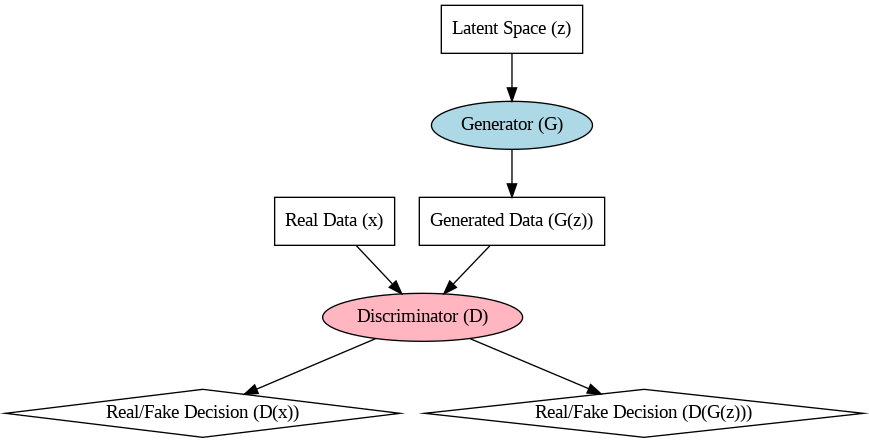

In [68]:
import pydot
from IPython.display import Image, display

def plot_gan_architecture():

    graph = pydot.Dot(graph_type="digraph")


    G = pydot.Node("Generator (G)", style="filled", fillcolor="lightblue")
    D = pydot.Node("Discriminator (D)", style="filled", fillcolor="lightpink")


    noise_input = pydot.Node("Latent Space (z)", shape="box")
    real_data_input = pydot.Node("Real Data (x)", shape="box")
    generated_data = pydot.Node("Generated Data (G(z))", shape="box")
    decision_real = pydot.Node("Real/Fake Decision (D(x))", shape="diamond")
    decision_generated = pydot.Node("Real/Fake Decision (D(G(z)))", shape="diamond")


    graph.add_node(G)
    graph.add_node(D)
    graph.add_node(noise_input)
    graph.add_node(real_data_input)
    graph.add_node(generated_data)
    graph.add_node(decision_real)
    graph.add_node(decision_generated)


    graph.add_edge(pydot.Edge(noise_input, G))
    graph.add_edge(pydot.Edge(G, generated_data))
    graph.add_edge(pydot.Edge(real_data_input, D))
    graph.add_edge(pydot.Edge(generated_data, D))
    graph.add_edge(pydot.Edge(D, decision_real))
    graph.add_edge(pydot.Edge(D, decision_generated))


    graph.write_png("gan_architecture.png")
    display(Image(filename="gan_architecture.png"))

plot_gan_architecture()
